PREDICTING VOLATILITY

GOALS
1. Create wrangle function for calculating returns.
2. Explore Volatility for Apple and Tesla Stock.
3. Build GARCH Model to predict TESLA Stock Volatility.
4. Create a clean prediction functiion for formatting model predictions. 

In [89]:
import pandas as pd
import plotly.express as px
import numpy as np

!pip install arch
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Defaulting to user installation because normal site-packages is not writeable


In [90]:
from arch import arch_model
import sqlite3
import matplotlib.pyplot as plt

PREPARE DATA: IMPORT DATA

Connect to Database

In [91]:
# Connect to database
connection = sqlite3.connect("/home/denis/Stock-Data/sqlite.db", check_same_thread=False)

# Create an isnstace of the SQLRepository class
repo = SQLRepository(connection=connection)


Read TESLA Stock Data From Database

In [92]:
df_tesla = repo.read_table(table_name="TSLA", limit=2500)

Wrangle Data Function

In [93]:
def wrangle_data(ticker, n_observations):
    """
    Extract data from the database. Calculate stock returns

    Args:
        ticker (str): The table name of the stock.
        n_observations (int): Number of observations to return.
    
    Returns:
        returns (pd.Series): Name will be returns no NAN values.
    """
    
    # Get data drom database
    df = repo.read_table(table_name=ticker, limit=n_observations)
    
    # Sort dataframe ascending by date
    df.sort_index(ascending=True, inplace=True)
    
    # Create "return" column
    df["return"] = df[" close"].pct_change() * 100
    
    return df["return"].dropna()
    

Tests On Wrangle Funciton

In [94]:
y_tesla = wrangle_data(ticker="TSLA", n_observations=2501)

# Is "y_tesla" a series
assert isinstance(y_tesla, pd.Series)

# Are there 2500 observations in "y_tesla"
assert len(y_tesla) == 2500

# Is "y_tesla" name "return"
assert y_tesla.name == "return"

# Is Index Sorted Ascending
assert all(y_tesla.index == y_tesla.sort_index(ascending=True).index)

# There are no NAN values
assert y_tesla.isnull().sum() == 0

y_tesla.head()

date
2014-10-22   -1.801649
2014-10-23    1.813068
2014-10-24   -0.021250
2014-10-27   -5.768577
2014-10-28    9.518654
Name: return, dtype: float64

Read Apple Data from Database

In [95]:
y_apple = wrangle_data(ticker="AAPL", n_observations=2501)
y_apple.tail()

date
2024-09-23   -0.758107
2024-09-24    0.397404
2024-09-25   -0.439812
2024-09-26    0.508018
2024-09-27    0.118671
Name: return, dtype: float64

EXPLORE DATA

Volatility Stock Plots

Volatility is the measure of the spread of returns around the mean. Plotting the returns of the two plots enable us to visually assess the volatility of the two stocks.

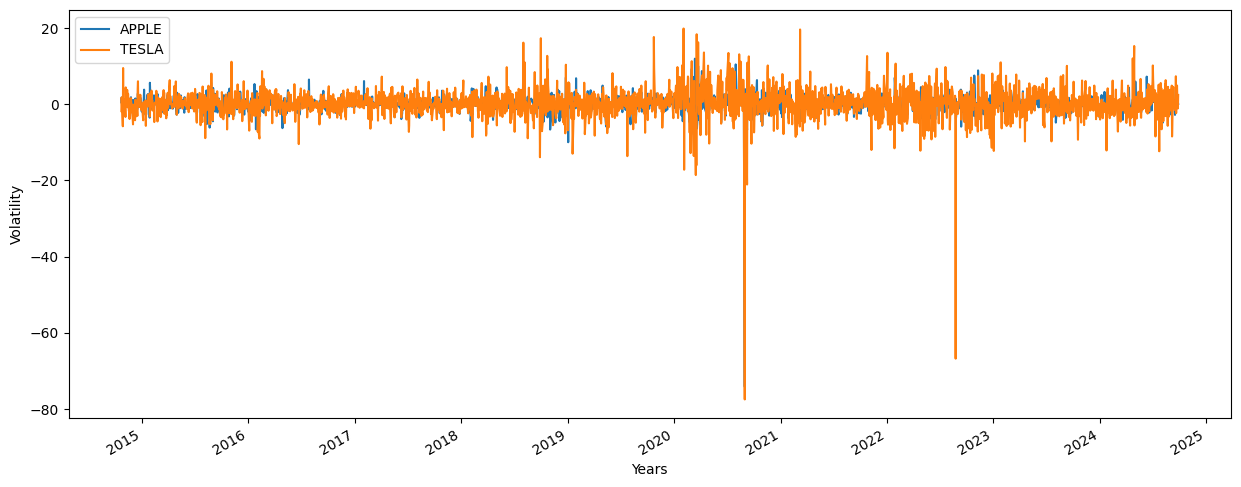

In [96]:
fig, ax = plt.subplots(figsize = (15, 6))

# Volatility Time Series Plot
y_apple.plot(ax=ax, label="APPLE")
y_tesla.plot(ax=ax, label="TESLA")

# Label axes
plt.xlabel("Years")
plt.ylabel("Volatility")

plt.legend();

Distributiion of Apple and Tesla Returns

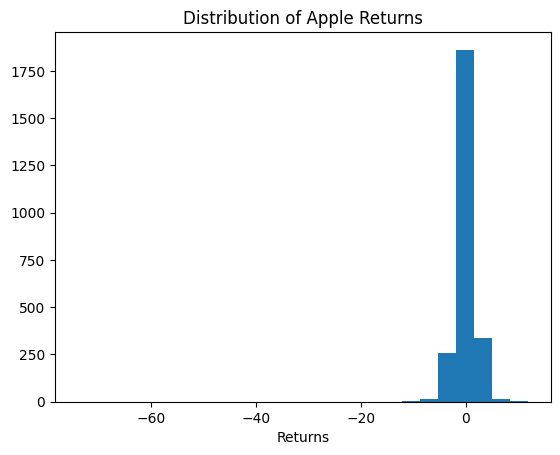

In [97]:
plt.hist(y_apple, bins=25)
plt.xlabel("Returns")
plt.title("Distribution of Apple Returns")
plt.show();

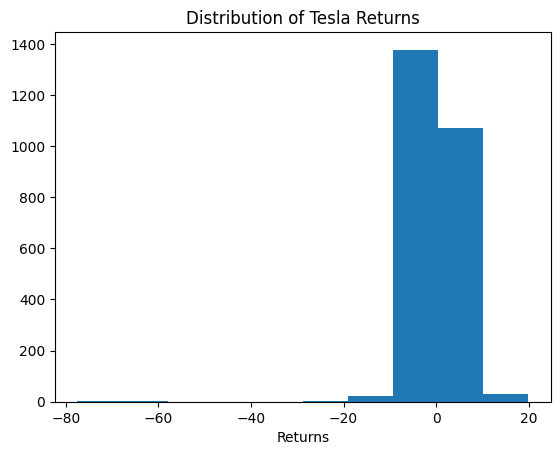

In [98]:
plt.hist(y_tesla, bins=10)
plt.xlabel("Returns")
plt.title("Distribution of Tesla Returns")
plt.show();

Daily Volatilitty

In [99]:
tesla_daily_volatility = y_tesla.std()
apple_daily_volatility = y_apple.std()

Annual Volatility

In [100]:
tesla_annual_volatility = tesla_daily_volatility * np.sqrt(252)
apple_annual_volatility = apple_daily_volatility * np.sqrt(252)

Rolling Volatility

This method calculates volatility over a moving time window, which updates as new data comes in. It reflects the changing risk environment over time.


In [101]:
tesla_rolling_50d_volatility = y_tesla.rolling(window=50).std().dropna()

Plot Rolling Volatility

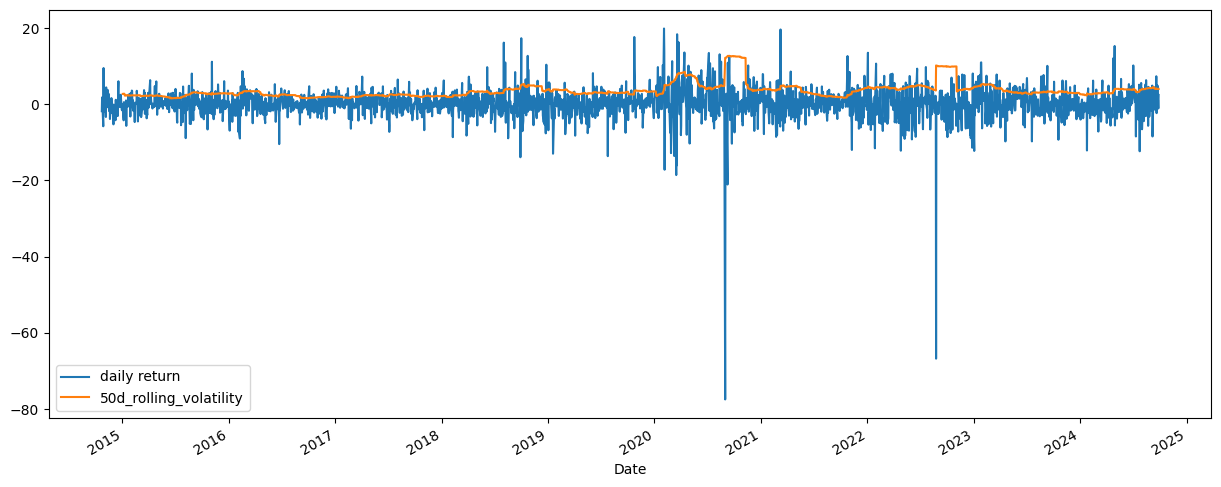

In [102]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot y_ambuja
y_tesla.plot(ax=ax, label="daily return")

# Plot rolling volatility
tesla_rolling_50d_volatility.plot(ax=ax, label="50d_rolling_volatility")

# Plot labels
plt.xlabel("Date")

# Add legend
plt.legend();

Plot Squared Returns: TESLA

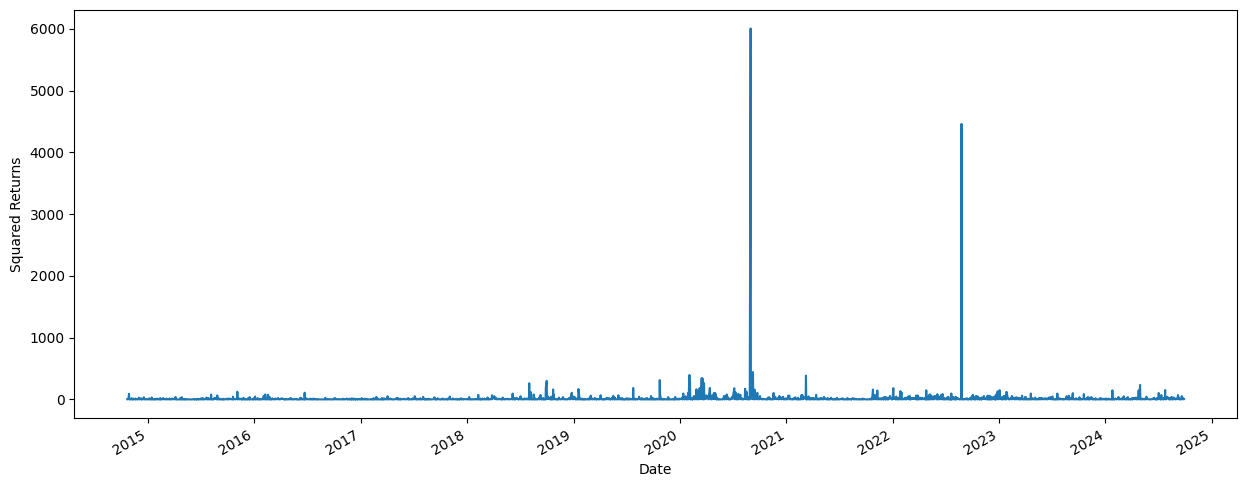

In [103]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_tesla ** 2).plot(ax=ax)

# Add labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

ACF of Squared Returns: TESLA

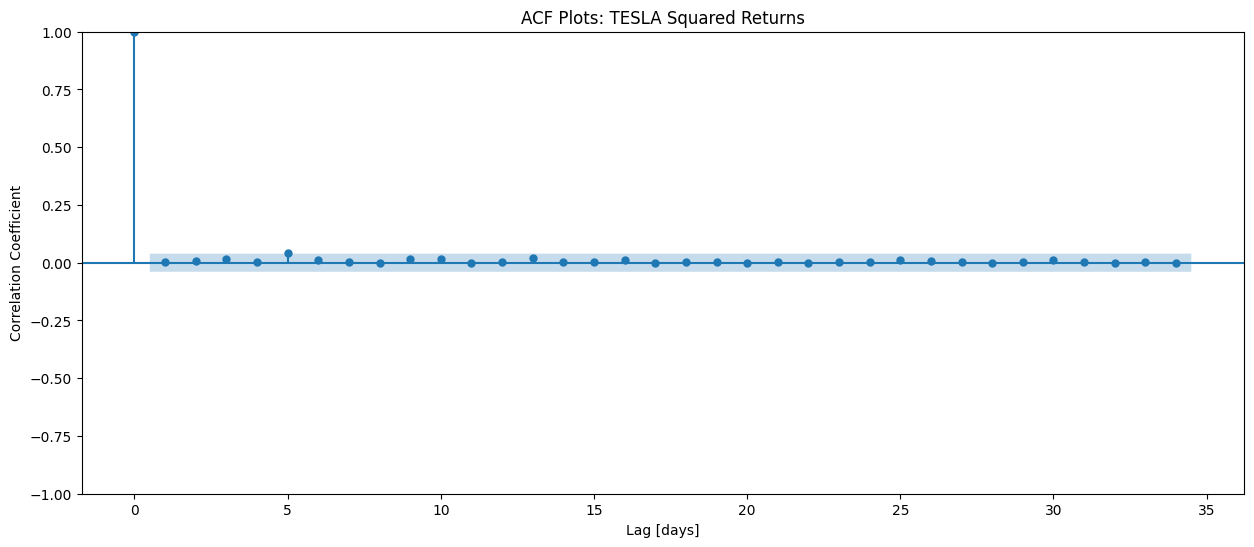

In [104]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF plot of squared returns
plot_acf(y_tesla ** 2, ax=ax)

# Add labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF Plots: TESLA Squared Returns");

PACF Plot

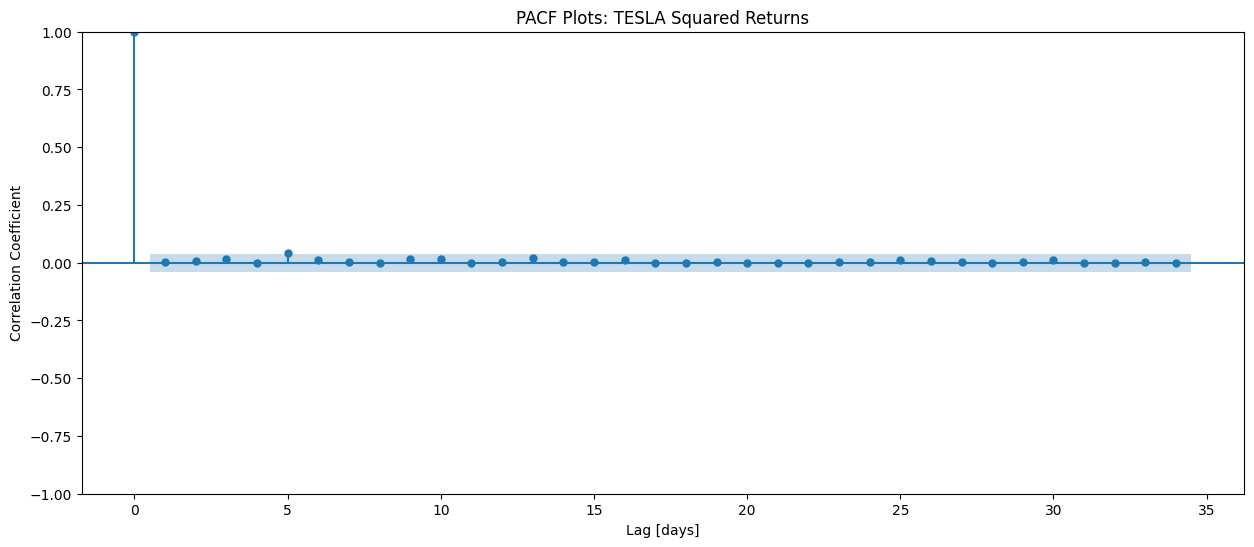

In [105]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF plot of squared returns
plot_pacf(y_tesla ** 2, ax=ax)

# Add labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")
plt.title("PACF Plots: TESLA Squared Returns");

SPLIT DATA

In [151]:
cutoff_test = int(len(y_tesla) * 0.8)
y_tesla_train = y_tesla.iloc[:cutoff_test]
y_tesla_test = y_tesla.iloc[cutoff_test:]

In [152]:
y_tesla_train.tail(1)

date
2022-09-30   -1.103613
Name: return, dtype: float64

In [153]:
y_tesla_test.tail(1)

date
2024-09-27    2.454567
Name: return, dtype: float64

BUILD MODEL

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is used to forecast time-varying volatility in financial time series, capturing volatility clustering. In this project, we fit a GARCH(1,1) model to predict conditional variance based on past returns and volatility.

In [154]:
# Build and train model
model = arch_model(
    y_tesla_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

# Model Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5478.83
Distribution:                  Normal   AIC:                           10965.7
Method:            Maximum Likelihood   BIC:                           10988.1
                                        No. Observations:                 2000
Date:                Mon, Sep 30 2024   Df Residuals:                     1999
Time:                        14:17:42   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0365  7.651e-02      0.477      0.633 [ -0.113,  0.186]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0320      0.123      0.262      0.794     [ -0.208,  0.272]
alpha[1]       0.0190  4.940e-03      3.847  1.196e-04 [9.322e-03,2.869e-02]
beta[1]        0.9810  1.664e-02     58.967      0.000     [  0.948,  1.014]
============================================================================

Covariance estimator: robust
"""

Plot Returns vs Predictions

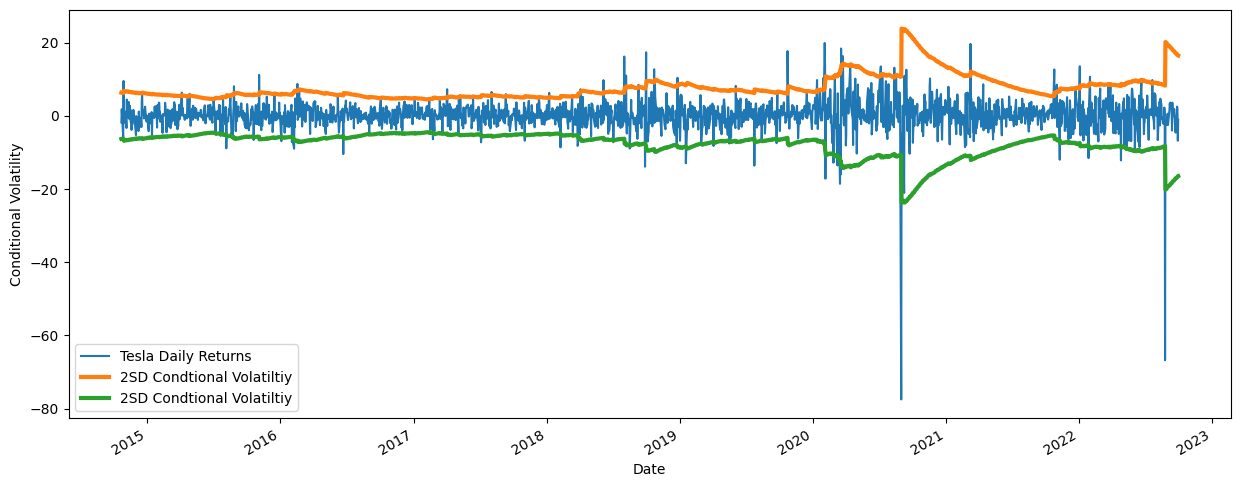

In [155]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot "y_tesla_train" returns
y_tesla_train.plot(ax=ax, label="Tesla Daily Returns")

# Plot Conditional Volatility * 2
(2 * model.conditional_volatility).plot(ax=ax, color="C1", label="2SD Condtional Volatiltiy", linewidth=3)

# Plot Conditional Volatility * -2
(-2 * model.conditional_volatility).plot(ax=ax, color="C2", label="2SD Condtional Volatiltiy", linewidth=3)

# Add labels
plt.xlabel("Date")
plt.ylabel("Conditional Volatility")

plt.legend();

Plot Standardized Residuals

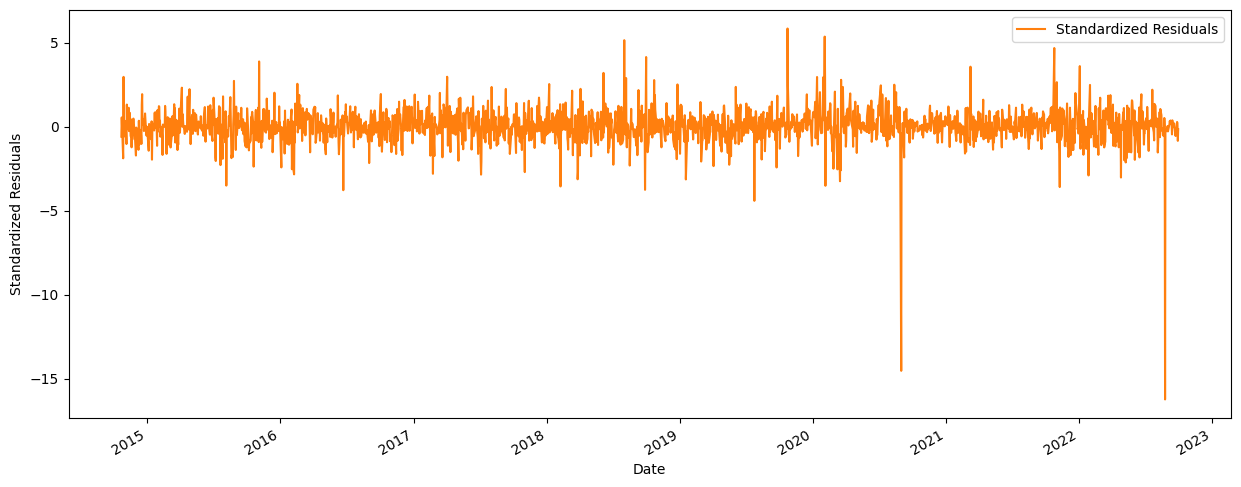

In [156]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot Standardized Residuals
model.std_resid.plot(ax=ax, color="C1", label="Standardized Residuals")

# Add axes
plt.xlabel("Date")
plt.ylabel("Standardized Residuals")

plt.legend();

Histogram of Standard Residuals

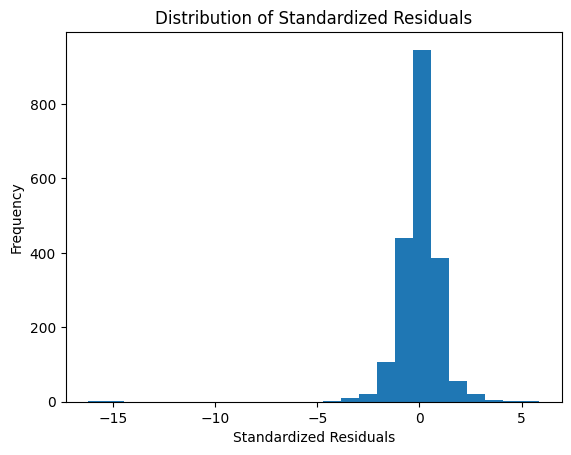

In [157]:
# Create histogram of standard residuals
plt.hist(model.std_resid, bins=25)

# Add labels
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Standardized Residuals");

ACF of Standard Residuals

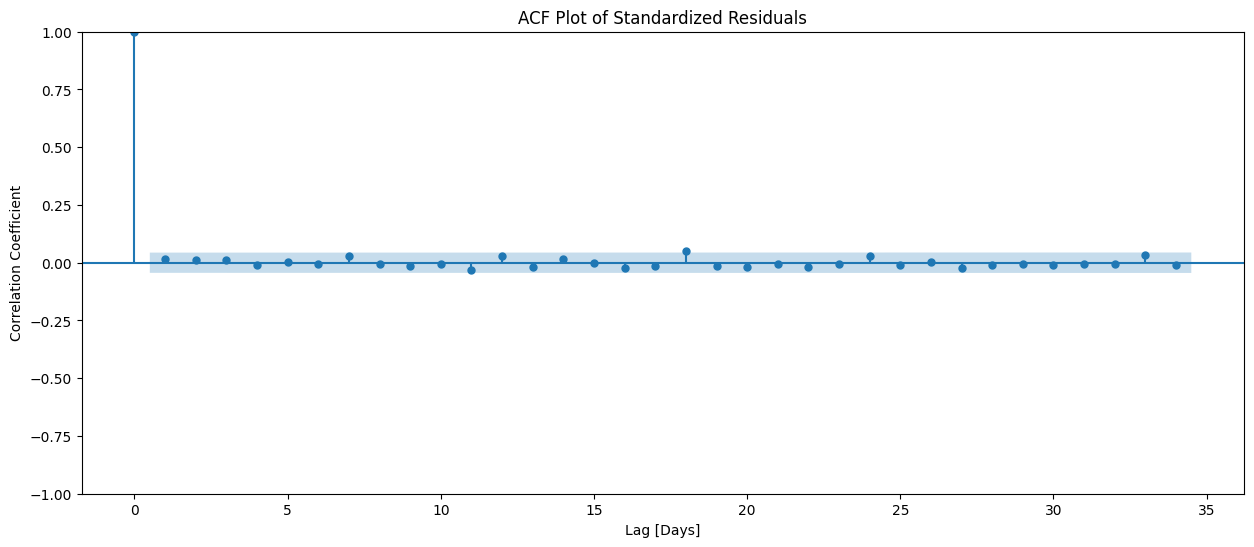

In [158]:
fig, ax = plt.subplots(figsize= (15,6))

# Plot ACF of "Standardized Residuals"
plot_acf(model.std_resid, ax=ax)

# Add labels
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient")
plt.title("ACF Plot of Standardized Residuals");

EVALUATE

One Day Forecast

In [159]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance
one_day_forecast.iloc[0, 0] ** 0.5

np.float64(8.15727305961798)

In [160]:
y_tesla_train.tail(1)

date
2022-09-30   -1.103613
Name: return, dtype: float64

In [161]:
y_tesla_test.head(1)

date
2022-10-03   -8.614515
Name: return, dtype: float64

Walk Forward Validation

In [163]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data(20%)
test_size = int(len(y_tesla) * 0.2)

# Walk Forward Validation
for i in range(test_size):
    # Create test data
    y_tesla_test = y_tesla_train.iloc[:-(test_size-i)]
    
    # Train model
    model = arch_model(y_tesla_train, p=1, q=1, rescale=False).fit(disp=0)
    
    # Generate next prediction "volatility"
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0, 0] ** 0.5
    
    # Append Prediction to list
    predictions.append(next_pred)
    
# Create series from predictions list
y_tesla_test_wfv = pd.Series(predictions, index=y_tesla_test.tail(test_size).index)

print("y_tesla_test_wfv type:", type(y_tesla_test_wfv))
print("y_tesla_test_wfv shape:", y_tesla_test_wfv.shape)
y_tesla_test_wfv.tail()

y_tesla_test_wfv type: <class 'pandas.core.series.Series'>
y_tesla_test_wfv shape: (500,)


date
2022-09-23    8.157273
2022-09-26    8.157273
2022-09-27    8.157273
2022-09-28    8.157273
2022-09-29    8.157273
dtype: float64

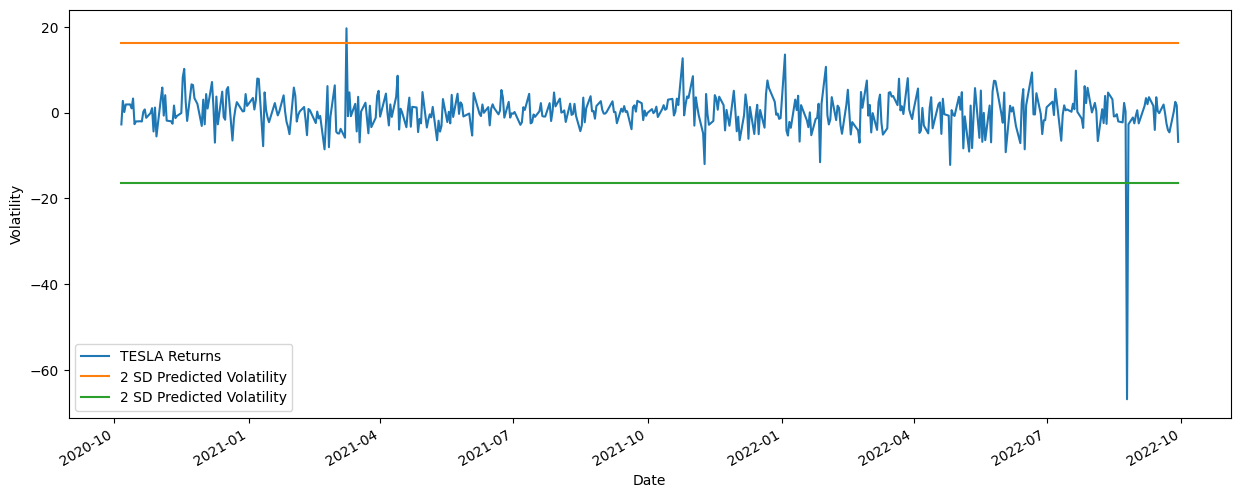

In [166]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_tesla_test.tail(test_size).plot(ax=ax, label="TESLA Returns")

# Plot Volatility Predictions * 2
(2 * y_tesla_test_wfv).plot(ax=ax, color="C1", label="2 SD Predicted Volatility")

# Plot Volatility Predictions * -2
(-2 * y_tesla_test_wfv).plot(ax=ax, color="C2", label="2 SD Predicted Volatility")

# Label axes
plt.xlabel("Date")
plt.ylabel("Volatility")

plt.legend();

Communicate Results

In [167]:
# Generate 5 day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5

# Calculate forcast start date
start = prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index labels, ISO-8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index lenght:", len(prediction_index))
prediction_index[:5]


prediction_index type: <class 'list'>
prediction_index lenght: 5


['2022-10-03T00:00:00',
 '2022-10-04T00:00:00',
 '2022-10-05T00:00:00',
 '2022-10-06T00:00:00',
 '2022-10-07T00:00:00']

Clean Predicition Function

In [168]:
def clean_prediction(prediction):
    """ Reformat model predictions to JSON

    Args:
        prediction (pd.DataFrame: Variance from GARCH model forecast
    
    Returns:
        dict: Forecast of volatility. Each key is date in ISO-8601 format. Each value is predicted volatility.
    """
    
    # Access forecasted variance (last row contains the horizon forecast)
    forecasted_variance = prediction.variance.values[-1]  # Variance for the forecast horizon
    
    # Calculate forecast start date (one day after the last date in the original data)
    start = pd.Timestamp.today() + pd.DateOffset(days=1)  # Replace with actual forecast start date
    
    # Create date range for forecast horizon
    prediction_dates = pd.bdate_range(start=start, periods=len(forecasted_variance))  # Business days
    
    # Create prediction index labels in ISO-8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]

    # Calculate the volatility by taking the square root of the forecasted variance
    data = forecasted_variance ** 0.5
    
    # Combine data and prediction index into a dictionary
    prediction_formatted = {date: vol for date, vol in zip(prediction_index, data)}
    
    # Return the formatted prediction as a dictionary
    return prediction_formatted

Generate Predictions

In [169]:
prediction = model.forecast(horizon=10, reindex=False)

prediction_formatted = clean_prediction(prediction)

prediction_formatted

{'2024-10-01T00:00:00': np.float64(8.15727305961798),
 '2024-10-02T00:00:00': np.float64(8.159269409201586),
 '2024-10-03T00:00:00': np.float64(8.161265286173233),
 '2024-10-04T00:00:00': np.float64(8.163260690879696),
 '2024-10-07T00:00:00': np.float64(8.16525562366733),
 '2024-10-08T00:00:00': np.float64(8.167250084882074),
 '2024-10-09T00:00:00': np.float64(8.169244074869445),
 '2024-10-10T00:00:00': np.float64(8.17123759397454),
 '2024-10-11T00:00:00': np.float64(8.17323064254204),
 '2024-10-14T00:00:00': np.float64(8.175223220916207)}